# Test Confident Learning Classifier on Assembled Dataset

Notes: - Includes data from 1st March 2020 - 31st March 2021 \
Method: CleanLab package for learning with noisy labels

## Importing libraries and dataset

In [1]:

# Import Libraries
import import_ipynb
from importlib import reload

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm

from cleanlab.classification import LearningWithNoisyLabels


In [2]:

# Import dataset
ReadCSV = False
if ReadCSV:
    df_ini = pd.read_csv(r'O:\GIRFT DiRAC\FlavienHardy\2_NosocomialInfections\src\0.processing\data\NI_Final.csv')


In [3]:

# Set X matrix and y vector
ColumnList =['Unnamed: 0', 'NI_1p2_15', 'NC_Method1', 'NC_Method2_15', 'NC_Method2_8','NC_Method4', 'NI_AllMethods']
X_ini = df_ini.drop(columns=ColumnList)
y_ini = df_ini['NI_AllMethods']

print('Total number of discharges', X_ini.shape[0])
print('Number of features', X_ini.shape[1])
print('Number of NI', y_ini.sum())
print('Proportion of NI', 100*y_ini.sum()/y_ini.shape[0])


Total number of discharges 366859
Number of features 101
Number of NI 29642
Proportion of NI 8.079943520535137


## Split and Train

In [47]:

# Split into training, validation | test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X_ini, y_ini, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state=42)


In [48]:

#---------------- TESTING ----------------

BalanceTraining = False

if BalanceTraining:

    # balancing training set
    n_NI_Train = X_train[y_train==1].shape[0]
    print('Initial number of NI:', n_NI_Train)
    print('Initial NI proportion:',100*n_NI_Train/X_train.shape[0])

    from imblearn.under_sampling import RandomUnderSampler
    RUS = RandomUnderSampler(random_state=42)
    RUS.fit(X_train, y_train)
    X_train_balanced, y_train_balanced = RUS.fit_resample(X_train, y_train)

    print('New number of NI:', X_train_balanced[y_train_balanced==1].shape[0])
    print('New number of non-NI:', X_train_balanced[y_train_balanced==0].shape[0])

    # Replacing training set with balanced one
    X_train = X_train_balanced
    y_train = y_train_balanced

#---------------- TESTING ----------------



In [59]:

# Define classifier
clf_RF = RandomForestClassifier(n_estimators=279,
                                min_samples_split=10,
                                min_samples_leaf=2,
                                max_depth=62,
                                max_features='auto',
                                bootstrap=True,
                                class_weight=None)

# Wrap learningWithNoisyLabels class around classifier
lnl = LearningWithNoisyLabels(clf=clf_RF,
                              prune_method='both')

# Train wrapped classifier
lnl.fit(np.array(X_train), np.array(y_train))


RandomForestClassifier(max_depth=62, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=279)

## Evaluation: ROC Curve

In [75]:

# Find predicted vectors
y_pred_train = lnl.predict(np.array(X_train))
y_pred_val_proba = lnl.predict_proba(np.array(X_val))

# Change Probablity Threshold
Threshold_Val = 0.25
y_pred_val = [1 if y_pred_val_proba[i][1]>Threshold_Val else 0 for i in range(len(y_pred_val_proba))]
y_pred_val_proba =  y_pred_val_proba[:,1]


ROC AUC Value:  0.8859933273188745


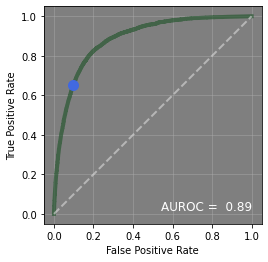

In [76]:

# Find AUROC
fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred_val_proba)
roc_auc = metrics.auc(fpr, tpr)
print('ROC AUC Value: ', roc_auc)

#----------------------------------------
# Plot ROC Curve

# --- Plot ROC Curve
fig, ax = plt.subplots()
CurveOpacity = 0.6
ColorCurve = (26/255, 81/255, 37/255, CurveOpacity)
plt.plot(fpr, tpr, color=ColorCurve, label='AUC = %0.2f' % roc_auc, linewidth=4, zorder=2)

# --- Plot Diagonal Line
ColorDiag = (220/255, 220/255, 220/255, CurveOpacity)
plt.plot([0, 1], [0, 1], color=ColorDiag, linestyle='--', linewidth=2, zorder=2)

# --- Plot current state on ROC curve
FilterThreshold = (threshold==Threshold_Val)
f_FPR = interp1d(threshold, fpr)
f_TPR = interp1d(threshold, tpr)
OpacityPoint = 1
ColorPoint = [65/255, 105/255, 225/255, OpacityPoint]
plt.scatter(x=f_FPR(Threshold_Val), y=f_TPR(Threshold_Val), s=100, color=ColorPoint, zorder=3)

# --- Options
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis('scaled')
plt.text(0.54, 0.02, 'AUROC =  %0.2f' % roc_auc, color='white', fontsize=12)
ax.set_facecolor([0, 0, 0, 0.5])
ax.grid(b=True, alpha=0.5, zorder=1)


## Plot and Analyse Confusion Matrix

Text(313.08000000000004, 0.5, 'Initial label')

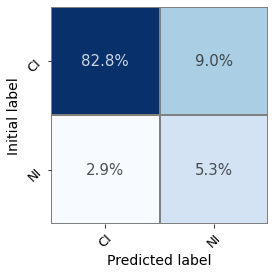

In [77]:

fig2, ax2 = plt.subplots(1, 1, figsize=(12, 4))

# Compute confusion matrix on validation set
CM = confusion_matrix(y_val, y_pred_val, normalize='all')

# Options for annotation and categories
annot_kws={'fontsize':15,
          'alpha':0.8}
Categories = ['CI', 'NI']

# Plot confusion matrix
res = sns.heatmap(CM, annot=True, fmt='0.1%', cmap='Blues', norm=LogNorm(),
           annot_kws=annot_kws,
           linewidth=2,
           xticklabels=Categories,
           yticklabels=Categories,
           square=True,
           cbar=False,
           linecolor='gray')

# Remove ticks on x and y axes
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=13, rotation=45)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=13, rotation=45)

# Add labels
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('Initial label', fontsize=14)


In [78]:

# New predicted NI rate on validation set
n_NI_pred = np.sum(y_pred_val)
n_Infections = len(y_pred_val)
Prop_pred = 100*n_NI_pred/n_Infections
print('Number of predicted NI:', n_NI_pred)
print('Out of:', n_Infections, 'infections.')
print('New predicted NI rate:', Prop_pred, '%')


Number of predicted NI: 8420
Out of: 58698 infections.
New predicted NI rate: 14.344611400729155 %


### Find TPR of each method

In [79]:

Index_pred_positives = list(X_val[ pd.array(y_pred_val)==1 ].index)
Index_pred_negatives = list(X_val[ pd.array(y_pred_val)==0 ].index)

def TPR_Method(Method):
    # Was initially identified as NI by method
    Index_method_positives = list( df_ini[df_ini[Method]==1].index )
    Index_method_negatives = list( df_ini[df_ini[Method]==0].index )

    Index_method_TP = list( set.intersection( set(Index_method_positives), set(Index_pred_positives) ) )
    Index_method_FN = list( set.intersection( set(Index_method_positives), set(Index_pred_negatives) ) )

    TPR_Method = 100 * len(Index_method_TP) / (len(Index_method_TP)+len(Index_method_FN))
    print('TPR of', Method, TPR_Method, '%')

Methods = ['NC_Method1', 'NC_Method2_15', 'NC_Method2_8', 'NC_Method4']
for method in Methods:
    TPR_Method(method)
    

TPR of NC_Method1 59.16978564137462 %
TPR of NC_Method2_15 93.38983050847457 %
TPR of NC_Method2_8 80.02539145154465 %
TPR of NC_Method4 19.791666666666668 %


### Find predicted label errors

In [106]:

from cleanlab.pruning import get_noise_indices

y_pred_val_proba = lnl.predict_proba(np.array(X_val))
label_error_indices = get_noise_indices(s=np.array(y_val),
                                       psx=np.array(y_pred_val_proba),
                                       sorted_index_method='normalized_margin')


In [118]:

label_error_indices2 = label_error_indices
print(df_ini.iloc[label_error_indices2, :]['NC_Method1'].sum())
print(df_ini.iloc[label_error_indices2, :]['NC_Method2_15'].sum())
print(df_ini.iloc[label_error_indices2, :]['NC_Method2_8'].sum())
print(df_ini.iloc[label_error_indices2, :]['NC_Method4'].sum())
len(label_error_indices2)


95
33
65
6


1672

## Extract Feature Importance

In [120]:

FeatureImportance = pd.DataFrame({'Features':list(X_train.columns), 'Importance':clf_RF.feature_importances_}).sort_values('Importance', ascending=False)
FeatureImportance[0:20]


,Features,Importance
4,Spell_Los,0.359211
34,Discharge_date_Delta,0.049718
0,IMD_score,0.045181
1,age_of_patient,0.043962
33,Patients_Count,0.040048
31,Charlson_Score,0.031809
94,HFRS_Band_Severe,0.030359
12,Total_Hopper_Domains,0.027901
91,dis_dest_Spell_Usual place,0.020661
2,SpellCCdays,0.018687
